---
## firewatchBC Prototype
---

# 1. Folium Map
### Requirements:

In [2]:
# Python Modules
import os
# Data Modules
import pandas
import geopandas as gpd
# Spatial Modules
import folium
import branca
from branca.element import Template, MacroElement 
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import math
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib.patches as mpatches
import datetime
from folium import IFrame
import base64

### Global Variables:

In [3]:
cwd = os.getcwd()
path = "app/static/assets/data/"

### Program Functions:

In [4]:
def clean(gdf, flag):
    '''
        Prepare data for mapping
            -> return gdf: geopandas geodataframe
    '''
    if flag == 'F':
        attrs = ['FIRE_NUMBE', 'FIRE_YEAR', 'IGNITION_D', 'FIRE_STATU', 'FIRE_CAUSE',
                 'FIRE_CENTR', 'ZONE', 'FIRE_ID', 'FIRE_TYPE', 'GEOGRAPHIC', 'LATITUDE',
                 'LONGITUDE', 'CURRENT_SI', 'geometry']
        gdf = gdf[attrs]
        gdf = gdf.rename(columns={'FIRE_NUMBE': 'FIRE_NUMBER', 'FIRE_STATU':'FIRE_STATUS',
                                  'CURRENT_SI': 'CURRENT_SIZE'})
        gdf.LONGITUDE = gdf.LONGITUDE.astype(float)
        gdf.LATITUDE = gdf.LATITUDE.astype(float)
        gdf.CURRENT_SIZE = gdf.CURRENT_SIZE.astype(float)

    return gdf

def radius(current_size):
    '''
        Calcuate radius of a circle in meters given area in hectares
            -> returns radius: in meters
    '''
    area = current_size * 10000
    radius = math.sqrt(area/math.pi)
    return radius

def create_map():
    '''
        Creates a folium map.
            -> returns map: folium map object  
    '''
    # Satellite Imagery URLs
    EsriImagery = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
    EsriAttr = "Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community"
    GoogleImagery = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'
    GoogleAttr = 'Google'

    # init Folium Map object
    map = folium.Map(location=[53.5, -124], zoom_start=6.25, tiles=None)
   
    # Add Base Layers to Folium Map object
    folium.TileLayer(tiles='CartoDB positron', min_zoom=5, show=True, name='CartoDB Positron').add_to(map)
    folium.TileLayer(tiles='CartoDB dark_matter', min_zoom=5, name='CartoDB Dark Matter').add_to(map)
    folium.TileLayer(tiles=EsriImagery, attr=EsriAttr, name="ESRI Satellite Imagery", min_zoom=5).add_to(map)
    folium.TileLayer(tiles=GoogleImagery, attr=GoogleAttr, name="Google Earth Satellite Imagery", min_zoom=5).add_to(map)

    # Add Layer Control and custom legend (HTML)
    folium.map.LayerControl(collapsed=False, style = 'background-color: red;').add_to(map)
    template = ''
    with open("app/templates/layouts/legend.html", "r", encoding='utf-8') as f:
        template = f.read()

    # Add legend as branca element
    macro = MacroElement()
    macro._template = Template(template)
    map.get_root().add_child(macro)
    
    return map

def to_html(map, path, fname):
	'''
		Converts a map to html and saves in the given path location
	'''

	map.save(fname)
	os.replace(cwd+'/'+fname, cwd+path+'/'+fname)

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def match_value(df, col1, x, col2):
    """ Match value x from col1 row to value in col2. """
    return df[df[col1] == x][col2].values[0]

def haversine(coord1, coord2):
    '''
        https://gis.stackexchange.com/questions/293310/how-to-use-geoseries-distance-to-get-the-right-answer
    '''
    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    meters = round(meters)
    km = round(km, 3)
    return km

### Create Overlays:

In [5]:
# Read in Current Fire Points Dataset to geodataframe
# Process data using clean() function
fire_path = path+'current_fire_points/prot_current_fire_points.shp'
fire_pts = gpd.read_file(fire_path)
fire_pts = clean(fire_pts, 'F')

station_path = path+'BritishColumbia_WeatherStations/BritishColumbia_WeatherStations.shp'
station_pts = gpd.read_file(station_path)

station_pts = station_pts[station_pts.Climate_ID != 0.0]

station_pts['point'] = [(x, y) for x,y in zip(station_pts['Latitude__'], station_pts['Longitude_'])]
fire_pts['point'] = [(x, y) for x,y in zip(fire_pts['LATITUDE'], fire_pts['LONGITUDE'])]

fire_pts['NN'] = [closest_point(x, list(station_pts['point'])) for x in fire_pts['point']]
fire_pts['Climate_ID'] = [match_value(station_pts, 'point', x, 'Climate_ID') for x in fire_pts['NN']]
fire_pts['Station_Na'] = [match_value(station_pts, 'point', x, 'Station_Na') for x in fire_pts['NN']]


### Mapping:

In [119]:
encoded = base64.b64encode(open("test.png", 'rb').read()).decode()
width, height = 900, 300
html = '<h2>Minimum and Maximum Daily Temperature</h2> <img src="data:image/png;base64,{}"> <br/>                                                                                         <h2>Daily Precipitation</h2> <img src="data:image/png;base64,{}">'.format
iframe = IFrame(html(encoded, encoded), width=width+50, height=height+50)
popup = folium.Popup(iframe, max_width=2650)



# init Folium map
map = create_map()

# Add a proprotional circle maker to each fire point
# Add tool tips and popup information
# Styling
for i in range(0, len(fire_pts)):
    loc = fire_pts.GEOGRAPHIC[i]
    size = fire_pts.CURRENT_SIZE[i]
    status = fire_pts.FIRE_STATUS[i]
    id = fire_pts.Climate_ID[i]
    igd = fire_pts.IGNITION_D[i]
    name = fire_pts.Station_Na[i]
    dist = haversine(fire_pts.NN[i], fire_pts.point[i])

    color = 'black'
    fillColor = 'black'
    weight = 1.5
    fillOpacity = 0.75

    if(status == 'Out'):
        color = '#636363'
        fillColor = '#636363'
    elif(status == 'Under Control'):
        color = '#1a9850'
        fillColor = '#1a9850'
    elif(status == 'New'):
        color = '#d73027'
        fillColor = '#d73027'
    elif(status == 'Being Held'):
        color = '#fdae61'
        fillColor = '#fdae61'
    popup = ""
    try:
        
        encoded_temp = base64.b64encode(open("temp_figs/{}_temp.png".format(fire_pts.Climate_ID[i].astype(int)), 'rb').read()).decode()
        encoded_precip = base64.b64encode(open("precip_figs/{}_precip.png".format(fire_pts.Climate_ID[i].astype(int)), 'rb').read()).decode()
        width, height = 900, 300
        html = '<h2>Minimum and Maximum Daily Temperature</h2> <img src="data:image/png;base64,{}"> <br/>                                                                                         <h2>Daily Precipitation</h2> <img src="data:image/png;base64,{}">'.format
        iframe = IFrame(html(encoded_temp, encoded_precip), width=width+50, height=height+50)
        popup = folium.Popup(iframe, max_width=2650)
    except OSError as e:
        print("here")
        popup = "<b> Environment Canada Weather Data not available. </b>"

    folium.Circle(location = [fire_pts.LATITUDE[i], fire_pts.LONGITUDE[i]],
                  radius = radius(fire_pts.CURRENT_SIZE[i]),
                  tooltip = folium.features.Tooltip(text = '<h6> Fire Information </h6> <strong> Location: </strong> {} <br/> <strong> Fire Size (hectares): </strong> {} <br/>                                                              <strong> Ignition Day </strong> {} <br/> <strong> Fire Status: <span style="color:{}; font-size: 12px;"> {}                                                                      </span> </strong> <br/> <h6> Weather Station Information </h6> <strong> Closest Weather Station: </strong> {} km.                                                                <br> <strong> Station Name: </strong> {} <br/> <strong> Station ID: </strong> {}'
                                                           .format(loc, size, igd, color, status, dist, name, id),
                                                    style = 'background-color: #2c2c2c; color: white; font-size: 10px; padding: 10px;'),
                  color = color,
                  fill_color = fillColor,
                  weight = weight,
                  fillOpacity = fillOpacity,
                  popup=popup
                  
    ).add_to(map)
to_html(map, "", "app/templates/pages/map.html")

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


In [98]:
# Just Need to save this map as a .html file!
#to_html(map,'/templates/pages', 'map.html')

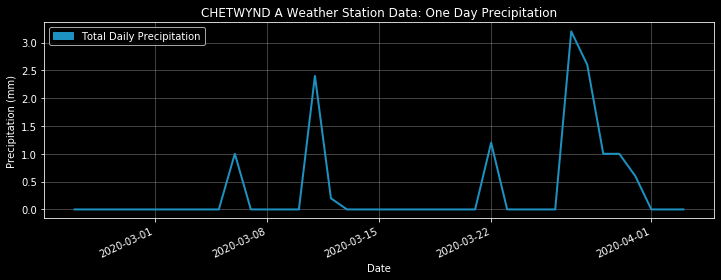

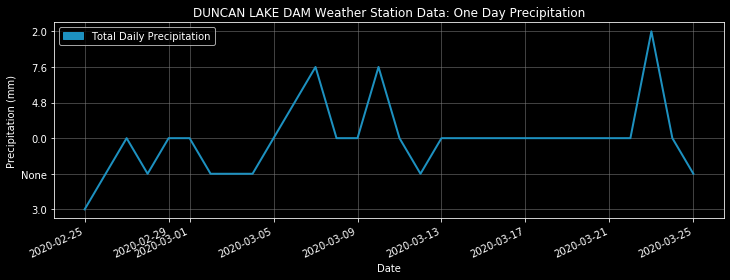

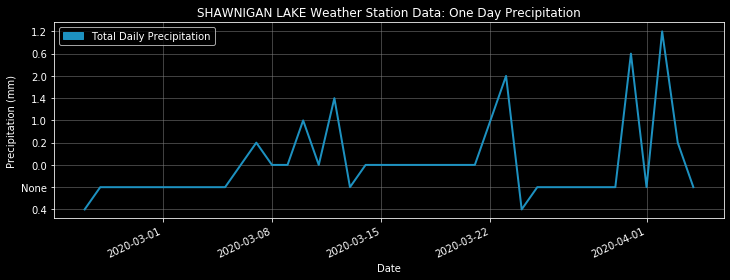

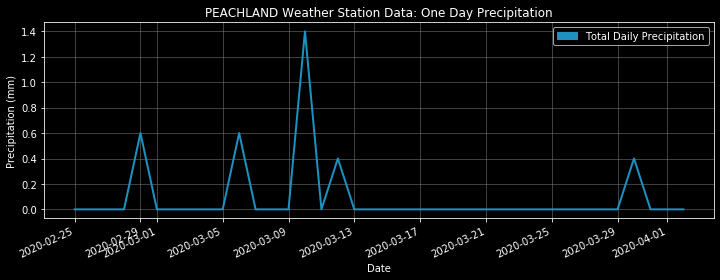

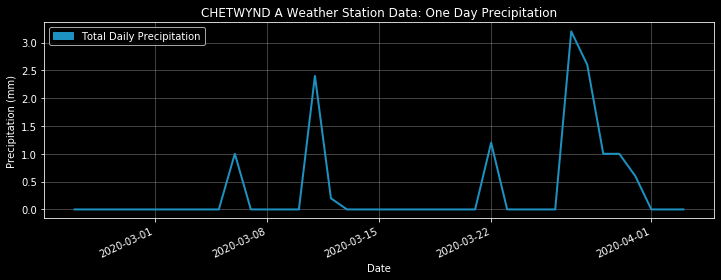

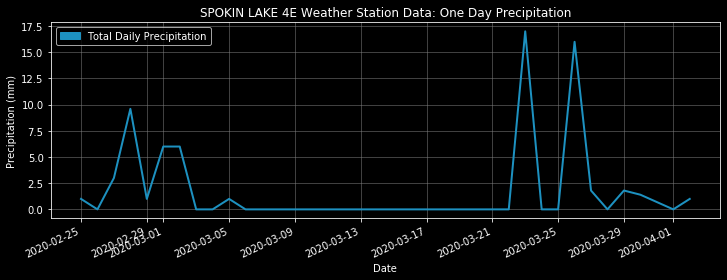

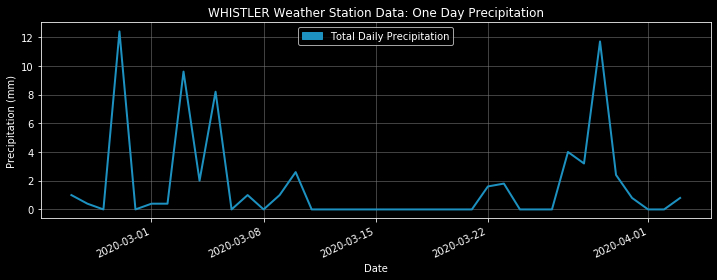

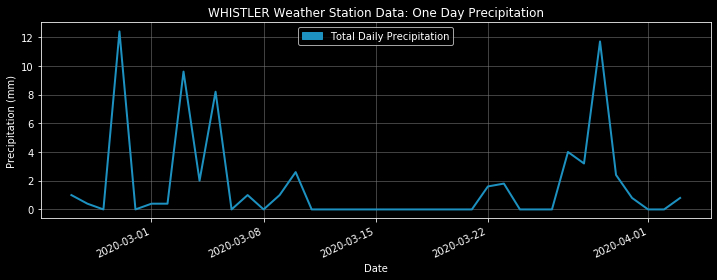

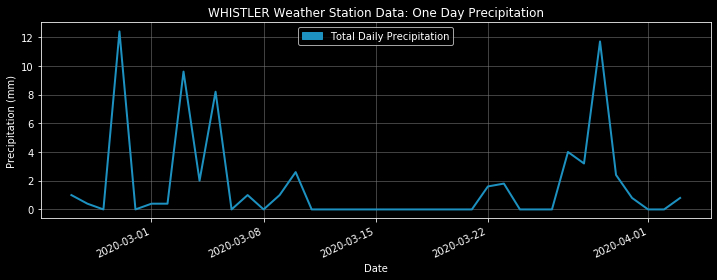

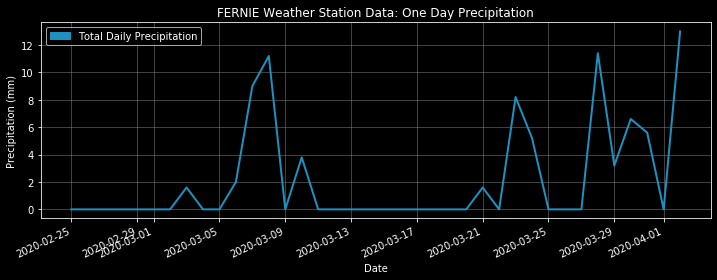

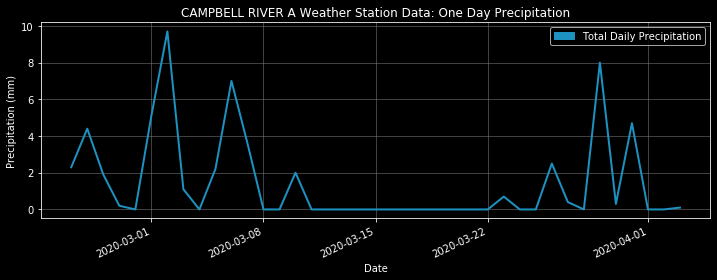

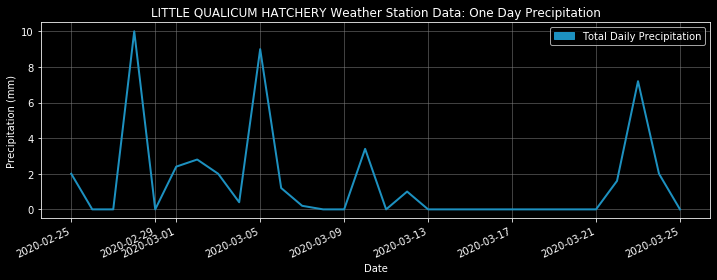

In [86]:
import numpy as np
import matplotlib.ticker as ticker

def format_date(df):
    for i in range(0, len(df)):
        t = df[' time'][i]
        t = t.replace(" ", "")
        t = t[0:10]
        df[' time'][i] = t
    df = df.rename(columns={" time": "date"})
    return df

chart_type = ["One Day Precipitation", "Daily Maximum and Minimum Temperatures"]
for id in fire_pts.Climate_ID.astype(int):
    try:
        df = pd.read_csv("app/static/assets/data/EC/{}.ascii".format(id), header=1)
        df.replace("" , 0.0)
        df.fillna(0.0, inplace=True)
        df = format_date(df)
    except OSError as e:
        continue

    name = fire_pts.Station_Na[fire_pts.Climate_ID == id].unique()
    igd = fire_pts.IGNITION_D[fire_pts.Climate_ID == id].unique()
    
    # Matplotlib
    fig, ax = plt.subplots(figsize=(12, 4))
    title = "{} Weather Station Data: {}".format(name[0], chart_type[0])
    ax.set(xlabel='Date', ylabel='Precipitation (mm)', title=title)
    plt.grid(color='grey', lw=0.5)
    plt.style.use('dark_background')

    converted_dates = matplotlib.dates.datestr2num(df.date)
    
    precip = df.ONE_DAY_PRECIPITATION
    max_temp = df[' MAX_TEMP']
    min_temp = df[' MIN_TEMP']

    max_l = mpatches.Patch(color='#1d91c0', label='Total Daily Precipitation')
    #min_l = mpatches.Patch(color='#fecc5c', label='Minimum Temperature')

    plt.legend(handles=[max_l])

    ax.plot_date(converted_dates, precip, '-' , color='#1d91c0', lw = 2.0)
    #ax.plot_date(converted_dates, min_temp, '-' , color='#fecc5c', lw = 2.0)
    plt.gcf().autofmt_xdate(rotation=25)
    png = '{}_precip.png'.format(id)
    fig.savefig("precip_figs/"+png, dpi=resolution)


In [77]:
encoded = base64.b64encode(open("test.png", 'rb').read()).decode()
width, height = 900, 310
lon, lat = -42, -21
html = '<h2>Minimum and Maximum Daily Temperature</h2> <img src="data:image/png;base64,{}"> <br/>                                                                                         <h2>Daily Precipitation</h2> <img src="data:image/png;base64,{}">'.format
iframe = IFrame(html(encoded, encoded), width=width, height=height)
popup = folium.Popup(iframe, max_width=2650)
icon = folium.Icon(color="red", icon="ok")
marker = folium.Marker(location=[lat-2, lon-1], popup=popup, icon=icon)
m = folium.Map(location=[lat, lon], zoom_start=5)
marker.add_to(m)
